# Microtask 5: 
Same as Microtask-4, but now using pandas.
> Produce a listing of repositories, as a table and as CSV file, with the number of commits authored, issues opened, and pull/merge requests opened, during the last three months, ordered by the total number (commits plus issues plus pull requests) (using pandas).

I am using the data source files of five repositories of FOSSASIA. They are 
- [badgeyay](https://github.com/fossasia/badgeyay) 
- [open-event-server](https://github.com/fossasia/open-event-server) 
- [phimpme-android](https://github.com/fossasia/phimpme-android) 
- [susi_android](https://github.com/fossasia/susi_android) 
- [susi_server](https://github.com/fossasia/susi_server) 

All the data source are located in the `data/` folder of the repository.

In [1]:
!pip install pandas
!pip install perceval

# Retrieving the data

You can also retrieve the data source files from the jupyter notebook itself. Just provide your `github_token` (github personal access token) and uncomment the code and run the code in the below cell.

In [2]:
github_token = "" # Please enter your github token here
owner = "fossasia"
repos = ["badgeyay", "open-event-server","phimpme-android","susi_android","susi_server"]
repos_url = ["https://github.com/" + owner + "/" + repo for repo in repos]
files = [repo+".json" for repo in repos] # file to which perceval stores data (a ../ is automatically added)

#for repo, repo_url, file in zip(repos, repos_url, files):
#    print(repo, repo_url, file)
#    !perceval git --json-line $repo_url >> ../$file
#    !perceval github --json-line --sleep-for-rate -t $github_token --category pull_request $owner $repo >> ../data/$file
#    !perceval github --json-line --sleep-for-rate -t $github_token --category issue $owner $repo >> ../data/$file

In [3]:
# json library is used to handle json files, here, it is the data source retrieved by the perceval module.
import json 
# to write and read csv files, to show the output in the end
import csv  

# importing pandas
# pandas is used for handling huge data using dataframe
import pandas as pd

# to handle the time formats, like to determine 'created_at' of an issue or pr.
from datetime import datetime, date, timedelta

# dictionaries are a convenient way to store data for later retrieval by name (key).
from collections import defaultdict  

# it is used to send http requests, I used to get the year in which the project created to do the analysis, using requests and github api.
import requests 

import matplotlib.pyplot as plt

In [4]:
# function to get the required details of commits
# commit has a different json structure unlike issue/pr

def details_commit(commit):
    # load the commit data into the object
    data = commit['data']
    # traverse through the json line to find the required data
    content ={
            # get the hash of the commit
            'hash': data['commit'],
            # get the author_name
            'author': data['Author'],  
            # get the date at which the commit was created
            'created_date': datetime.strptime(data['CommitDate'],"%a %b %d %H:%M:%S %Y %z")  
    }
    return content

In [5]:
# function to get the required details of issue/pull requests
# as issue/pr has the same json structure in the data source scraped by perceval
# I wrote a single function to get the either issue/pr details 

def details_ipr(item):
    # load the commit data into the object
    data = item['data']
    # traverse through the json line to find the required data
    content ={
            # get the hash of the issue/pr
            'hash': data['id'],
            # get the author_name
            'author': data['user']['login'],  
            # get the date at which the issue/pr was created
            'created_date': datetime.strptime(data['created_at'],"%Y-%m-%dT%H:%M:%SZ")  
    }
    return content 

In [6]:
def getContents(repo):
    
    # intializing the content dataframe with the required details
    content_df = {
        # commit has the column >> hash, author, date
        'commit':pd.DataFrame(columns=['hash', 'author', 'created_date']),
        # issue has the column >> hash, author, date
        'issue':pd.DataFrame(columns=['hash', 'author', 'created_date']),
        # pr has the column >> hash, author, date
        'pull_request':pd.DataFrame(columns=['hash', 'author', 'created_date'])
    }

    # contents is to store the details of each contribution whether it is a commit, issue or pr.
    # using a defaultdict of list so that I can store the sorted details according to the ctype as (key, value) 
    contents = defaultdict(list)
    
    # to filter out commit, issue, pr details from the data source and store them seperately in dict.
    # loading the file into an object
    with open('../data/%s.json'%repo) as datasrc:
        for line in datasrc:
            # load the line in the json format so as to iterate to get the required results
            line = json.loads(line)
            # if it is a commit, get the details of commit
            if line['category'] == 'commit':    
                content = details_commit(line) 
            # if it is a issue, get the details of issue
            elif line['category'] == 'issue':    
                content = details_ipr(line)
            # if it is a pr, get the details of pr
            elif line['category'] == 'pull_request':    
                content = details_ipr(line) 
            # add the (key, value) to the list
            contents[line['category']].append(content)
    for item in contents:
        content_df[item]=content_df[item].append(contents[item],sort=False)
    return content_df

In [7]:
# names of the repositories
repos = ['badgeyay','phimpme-android','susi_server','susi_android','open-event-server']

# contribution types
ctypes = ('commit','pull_request','issue')

# date before three months 
initial_date = datetime.combine(date.today() - timedelta(3*365/12), datetime.min.time())
    # REFERENCE: Stack Overflow https://stackoverflow.com/a/546356/8268998

# to store the total count of th contribution types
repodata = defaultdict(list)

# iterating through the repos
for repo in repos:
    # getting the contents to the dataframe of the repo by calling the function
    repo_df = getContents(repo)
    # initialized the total count to zero
    total = 0
    # iterating through the contribution types
    for ctype in ctypes:
        df = repo_df[ctype]
        # formatting the date according to the supported format
        df['created_date']= df['created_date'].apply(lambda x:x.replace(tzinfo=None))
        # replacing the dataframe after checking if it is in the last three months
        df = df[df['created_date'] >= initial_date]
        # append the ctyoe count to the dataframe using unique hash of ctype 
        repodata[ctype].append(df['hash'].nunique())

In [8]:
print("Repositories Details in the past three months\n")
for item in dict(repodata):
    # print the total activity quaterly
    print (item, dict(repodata)[item])  

Repositories Details in the past three months

commit [100, 155, 37, 78, 157]
pull_request [0, 0, 16, 140, 121]
issue [137, 345, 30, 262, 228]


In [9]:
# initializing the dataframe
qinfo = pd.DataFrame()
# filled the first column with repo names
qinfo['Repository'] = repos
# fill the second column with commit count
qinfo['# Commits'] = repodata['commit']
# fill the third column with issue count
qinfo['# Issues'] = repodata['issue']
# fill the fourth column with pull_request count
qinfo['# PullRequests'] = repodata['pull_request']
# fill the fifth column with computed total count
qinfo["# Total"] =qinfo.sum(axis=1)

In [10]:
# converting the dataframe to csv file
qinfo.to_csv('result.csv',index=None)

In [11]:
# reading the csv file
pd.read_csv('result.csv')

,Repository,# Commits,# Issues,# PullRequests,# Total
0,badgeyay,100,137,0,237
1,phimpme-android,155,345,0,500
2,susi_server,37,30,16,83
3,susi_android,78,262,140,480
4,open-event-server,157,228,121,506


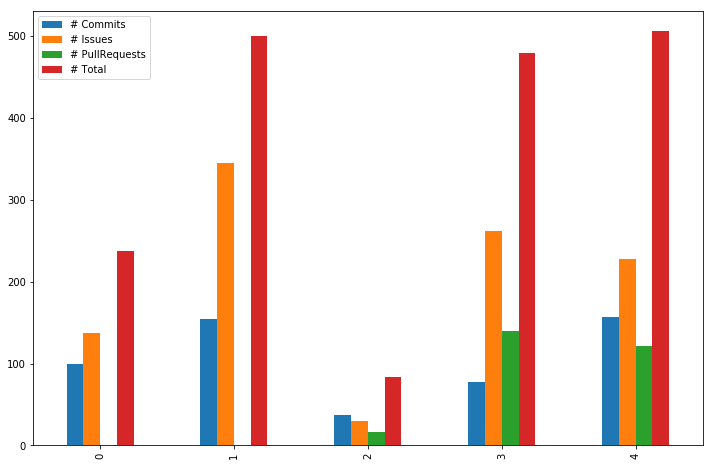

In [13]:
# plotting the data of the five repositories using a bar graph

df2 = pd.DataFrame(qinfo, columns=['# Commits', '# Issues', '# PullRequests', '# Total'])
df2.plot.bar(figsize=(12,8))